# <center> Идентификация пользователей по посещенным веб-страницам
# <center> Финальный отчет

Основной идеей проекта является решение задачи идентификации пользователя по последовательности посещенных веб-станиц и информации о длительности их посещения.
Цель проекта - идентифицировать пользователя по сессии из нескольких подряд посещенных сайтов. Объектом в этой задаче будет сессия из n сайтов, последовательно посещенных одним и тем же пользователем. Целевым классом будет id пользователя.
Для достижения поставленной цели требуется решение следующих задач:
- Подготовка обучающей выборки
- Первичный анализ данных, проверка гипотез
- Визуальный анализ данных и построение признаков
- Сравнение алгоритмов классификации и выбор лучшего алгоритма классификации из рассмотренного семейства алгоритмов с      точки зрения достижения максимального значения метрики
- Настройка лучшей модели

In [202]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
#pip install tqdm
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import itertools

In [165]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Исходные данные взяты с прокси-серверов Университета Блеза Паскаля и имеют следующий вид:

In [4]:
PATH_TO_DATA = 'capstone_user_identification'
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, '10users/user0031.csv'))
user31_data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


### Часть 1. Подготовка обучающей выборки

На основе исходных данных, сгруппированных в нескольких файлах, сформируем 2 едининых DataFrame (по данным 10 пользователей и 150 пользователей), в которых строки соответствуют уникальным сессиям из session_length сайтов, session_length столбцов – индексам этих session_length сайтов и последний столбец – ID пользователя и частотный словарь сайтов вида {'site_string': [site_id, site_freq]}.

In [8]:
train_data_10users = pd.read_csv(os.path.join(PATH_TO_DATA,'train_data_10users.csv'), index_col='session_id')
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,193,587,134,3,134,134,3,134,204,134,31
1,425,192,706,257,134,31,401,4913,221,55,31
2,55,3,55,55,5,295,425,341,936,55,31
3,486,4912,486,55,55,55,55,1006,202,124,31
4,349,55,5,4911,261,212,4910,2574,705,2574,31


In [9]:
train_data_150users = pd.read_csv(os.path.join(PATH_TO_DATA,'train_data_150users.csv'), index_col='session_id')
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,1,1,4,2,1,4,1,2,1298,322,6
1,2,23,1518,1298,322,322,113,73,49,49,6
2,322,205,1,1,1,1,73,322,2,1,6
3,1,1,7574,7574,5825,7574,7574,1,35,1,6
4,1,1,76,1,58,50,58,50,83,76,6


### 2. Первичный анализ данных, проверка гипотез

В настоящем разделе будем работать с данными о 10 пользователях

### 2.1. Убедимся, что рассматриваемый DataFrame не содержит пропусков

In [11]:
train_data_10users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
site1      14061 non-null int64
site2      14061 non-null int64
site3      14061 non-null int64
site4      14061 non-null int64
site5      14061 non-null int64
site6      14061 non-null int64
site7      14061 non-null int64
site8      14061 non-null int64
site9      14061 non-null int64
site10     14061 non-null int64
user_id    14061 non-null int64
dtypes: int64(11)
memory usage: 1.3 MB


### 2.2. Посмотрим на распределение целевого класса

In [17]:
train_data_10users['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

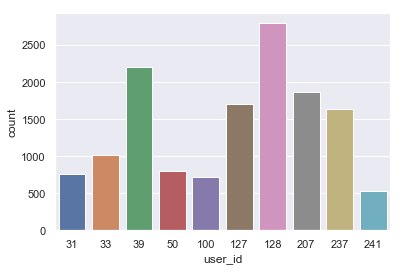

In [27]:
sns.set(style="darkgrid")
ax = sns.countplot(x="user_id", data=train_data_10users)

### 2.3. Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

In [29]:
num_unique_sites = [np.unique(train_data_10users.values[i, :-1]).shape[0] 
                    for i in range(train_data_10users.shape[0])]

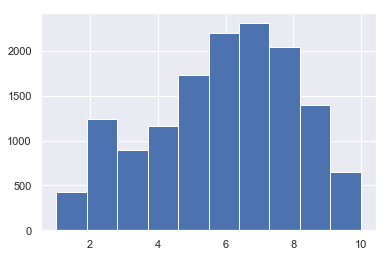

In [32]:
plt.hist(num_unique_sites)
plt.show()

#### С помощью QQ-плота и критерия Шапиро-Уилка проверим, распределена ли эта величина нормально

Populating the interactive namespace from numpy and matplotlib


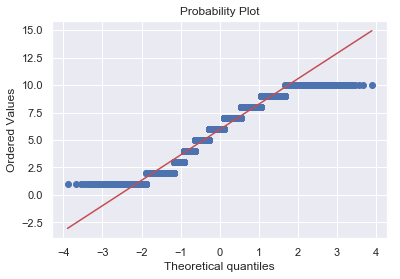

In [34]:
from statsmodels.stats.weightstats import *
%pylab inline
stats.probplot(num_unique_sites, dist = "norm", plot = pylab)
pylab.show()

##### Построенный Q-Q график имеет тяжелые хвосты и, следовательно, маловероятно что выборка взята из нормального распределения.

In [35]:
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(num_unique_sites))

C:\Users\Elena\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk normality test, W-statistic: 0.954693, p-value: 0.000000


##### Критерий Шапиро-Уилка отвергает гипотезу о нормальности распределения числа уникальных сайтов в каждой сессии на уровне p_value = 0

### 2.4. Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов

#### C помощью биномиального критерия для доли проверим, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95%.

In [48]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
L = len(num_unique_sites)
p = stats.binom_test(has_two_similar.sum(), L, 0.95, alternative = 'greater')
print (p)

0.02207653769072678


##### Таким образом, биномиальный критерий для доли отвергает поставленную гипотезу с достигаемым уровнем значимости p_value = 0.022. Другими словами, пользователи не склонны посещать одни и те же сайты очень часто и доля случаев, когда пользователь повторно посетил какой-то сайт меньше 95%.

#### Доверительный интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт:

In [50]:
from statsmodels.stats.proportion import proportion_confint
wilson_interval = proportion_confint(has_two_similar.sum(), len(num_unique_sites), method = 'wilson')
print('wilson_interval', '{} {}'.format(round(wilson_interval[0], 3), round(wilson_interval[1], 3)))

wilson_interval 0.95 0.957


### 2.5. Посмотирим на распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

In [51]:
L = pickle.load(open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb'))
names = []
freq = []
for x in range (0, len(L)):
    if sorted(L.values())[x][1] > 1000:
        names.append(sorted(L.values())[x][0])
        freq.append(sorted(L.values())[x][1])

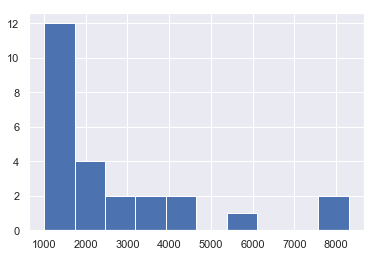

In [52]:
plt.hist(freq)
plt.show()

#### Построим 95% доверительный интервал для средней частоты появления сайта в выборке

In [54]:
all_freq = np.array(list(map(lambda x: x[1], sorted(L.values()))))

def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

mean_scores = list(map(np.mean, get_bootstrap_samples(all_freq, len(all_freq))))

print('Interval:', round(stat_intervals(mean_scores, 0.05)[0], 3), round(stat_intervals(mean_scores, 0.05)[1], 3))

Interval: 22.515 35.763


##### Согласно проведенного исследования можно заключить, что информация о посещенных сайтах позволяет разделять пользователей и может использоваться в качестве признаков в задаче классификации.

### 3. Визуальный анализ данных и построение признаков

#### Загрузим подготовленные дополнительные признаки для данных по 10 пользователям: session_timespan - продолжительность сессии в с, unique_sites - количество посещенных уникальных сайтов за сессию, start_hour - час начала сессии, day_of_week - день начала сессии

In [57]:
data = pickle.load(open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'rb'))
data.head()

,session_timespan,unique_sites,start_hour,day_of_week
0,33,5,8,4
1,284,10,8,4
2,258,7,8,4
3,30,6,8,4
4,6,9,8,4


#### 3.1. Построим гистограмму распределения длины сессии в секундах

(0, 200)

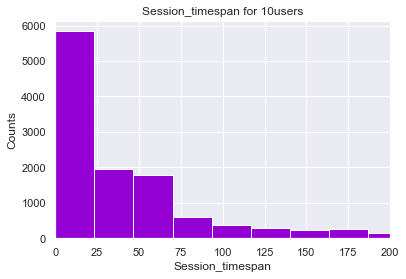

In [58]:
%matplotlib inline
data['session_timespan'].hist(grid=True, color='darkviolet', bins = 10000)
plt.title('Session_timespan for 10users')
plt.ylabel('Counts')
plt.xlabel('Session_timespan')
plt.xlim(0, 200)

Из графика видим, что большая часть сессий длится до 25 с.

#### 3.2. Построим гистограмму распределения числа уникальных сайтов в сессии (#unique_sites)

Text(0.5, 0, 'Unique_sites')

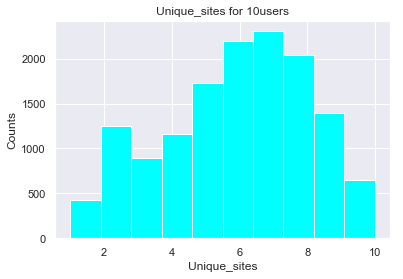

In [59]:
data['unique_sites'].hist(grid=True, color='aqua')
plt.title('Unique_sites for 10users')
plt.ylabel('Counts')
plt.xlabel('Unique_sites')

В представленных данных количество уникальных сайтов в сессии в большинстве составляет от 6 до 8 сайтов.

#### 3.3. Присвоим каждому из 10 id пользователей рассматриваемого dataset имена

#### Построим распределение количества уникальных сайтов в сессии по каждому из пользователей

In [68]:
data['target'] = train_data_10users['user_id']
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
data['target'] = data['target'].map(id_name_dict)

In [71]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

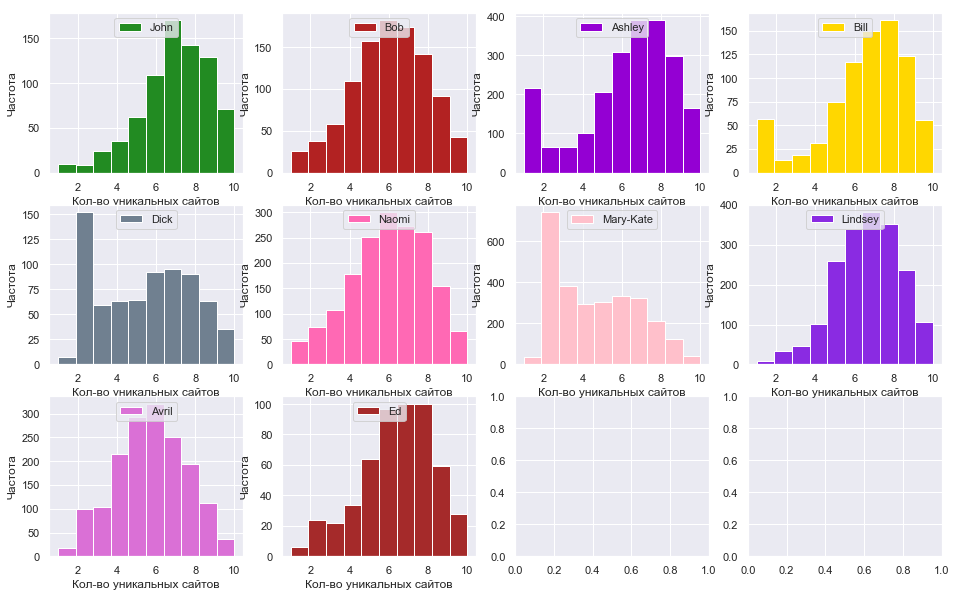

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
id_ = 0
for name in (data.target.unique()):
    id_ += 1
    plt.subplot(3, 4, id_)
    data[data.target == name].unique_sites.hist(color = color_dic[name], label=name)
    plt.legend(loc='upper center')
    plt.ylabel('Частота')
    plt.xlabel('Кол-во уникальных сайтов')

#### Построим гистограмму распределения часа начала сессии (start_hour)

Text(0.5, 0, 'Start_hour')

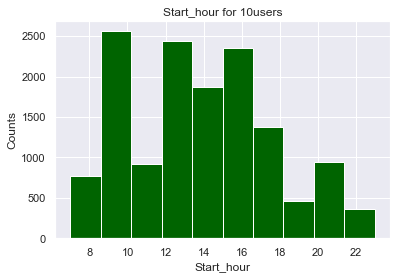

In [73]:
data['start_hour'].hist(grid=True, color='darkgreen')
plt.title('Start_hour for 10users')
plt.ylabel('Counts')
plt.xlabel('Start_hour')

#### Построим гаистограммы распределения часа начала сессии по каждому из пользователей

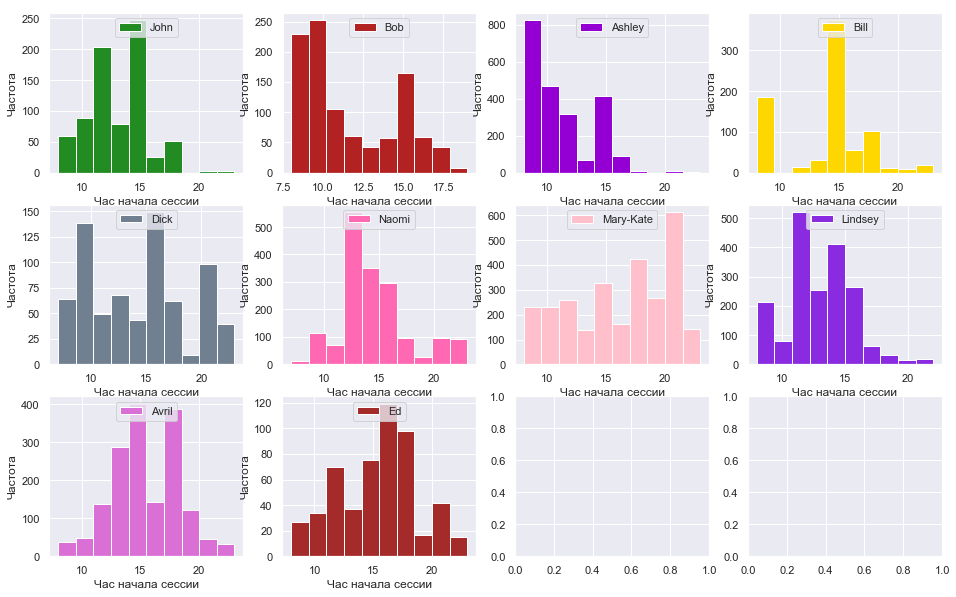

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
id_ = 0
for name in (data.target.unique()):
    id_ += 1
    plt.subplot(3, 4, id_)
    data[data.target == name].start_hour.hist(color = color_dic[name], label=name)
    plt.legend(loc='upper center')
    plt.ylabel('Частота')
    plt.xlabel('Час начала сессии')

#### Постоим гистограмму распределения дня недели, в который началась сессия (day_of_week)

Text(0.5, 0, 'Day_of_week')

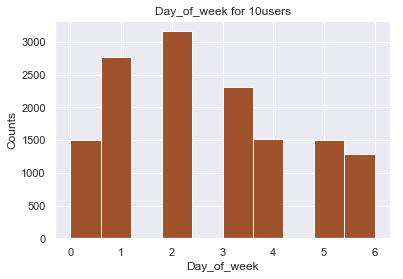

In [76]:
data['day_of_week'].hist(grid=True, color='sienna')
plt.title('Day_of_week for 10users')
plt.ylabel('Counts')
plt.xlabel('Day_of_week')

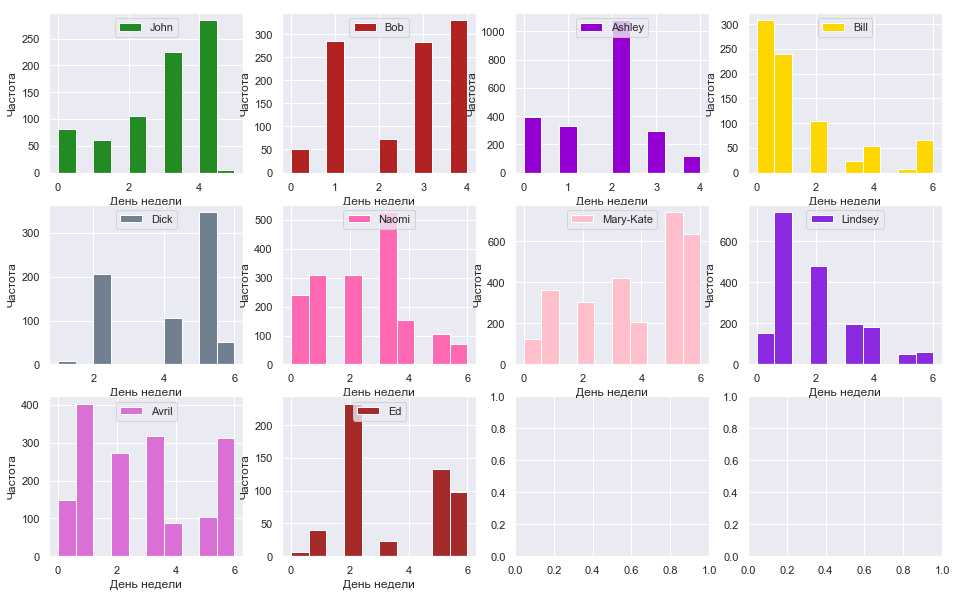

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
id_ = 0
for name in (data.target.unique()):
    id_ += 1
    plt.subplot(3, 4, id_)
    data[data.target == name].day_of_week.hist(color = color_dic[name], label=name)
    plt.legend(loc='upper center')
    plt.ylabel('Частота')
    plt.xlabel('День недели')

Согласно представленных распределений можно заключить, что рассмотренные признаки позволяют отделить одного пользователя от другого и можно выделить характерные закономерности по каждому из них:
1. John - в среднем посещает около 7 уникальным сайтов, пик посещений приходится на вторую половину дня (около 15 ч.), чаще всего сессии приходятся на выходные.
2. Bob - в среднем посещает около 6-8 уникальным сайтов, пик посещений приходится на утреннее время (около 10 ч.), сессии приходятся на будние дни. Можно предположить, что посещаемые сайты больше относятся к работе.
3. Ashley - похожа на Боба. В среднем посещает около 6-8 уникальным сайтов, пик посещений приходится на утреннее время (около 10 ч.), сессии приходятся на будние дни, особенно на среду. Можно предположить, что посещаемые сайты также больше относятся к работе.
4. Bill - В среднем посещает около 8 уникальным сайтов, пик посещений приходится на вторую половину дня (около 15 ч.), сессии приходятся на будние дни, особенно на понедельник. Можно предположить, что посещаемые сайты также больше относятся к работе.
5. Dick - в среднем посещает 2 сайта, делает это обычно утром и во второй половине дня, и чаще всего в выходные дни. Скорее всего, активность в сети мало связана с работой.
6. Naomi - Более- менее равномерная активность. 6-8 сайтов примерно во второй половине дня всю неделю. Можно предположить, что это набор из наиболее популярных сайтов и, возможно, Naomi достаточно социально активна.
7. Mary-Kate - обычно около 2-х уникальных сайтов в вечернее время, пики активности приходятся на конец недели. Скорее всего, активнось в сети также не связана с работой.
8. Lindsay - посящает 6-8 сайтов с 10.00 до 15.00 чаще в будние дни. Наверно, связано с работой.
9. Avril - похожа на Naomi. Более- менее стабильная активность.  Можно предположить, что это набор из наиболее популярных сайтов и, возможно, Avril достаточно социально активна.
10. Ed - 6-8 сайтов во второй половине дня 2-3 раза в неделю.

In [81]:
data2 = pickle.load(open(os.path.join(PATH_TO_DATA, 'selected_features_10users.pkl'), 'rb'))
data2['target'] = data['target']
data2.head()

,session_timespan,unique_sites,start_hour,day_of_week,clients2.google.com,mts0.google.com,talkgadget.google.com,accounts.google.fr,api.twitter.com,translate.google.fr,...,r3---sn-gxo5uxg-jqbe.googlevideo.com,apis.google.com,www.facebook.com,mail.google.com,www.google.com,www.google.fr,s.youtube.com,event_top30,multi,target
0,33,5,8,4,0,0,2,0,0,0,...,0,0,0,0,0,0,0,1,4,John
1,284,10,8,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,John
2,258,7,8,4,0,0,1,0,1,0,...,0,0,0,0,0,0,0,2,8,John
3,30,6,8,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,John
4,6,9,8,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,4,John


#### Посмотрим на количество посещений пользователями некоторых сайтов из списка топ-30

In [119]:
from seaborn import set

In [145]:
df_2 = data2.groupby('target').sum()
df_2.reset_index(inplace=True)
def site_plot(site):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x='target', y=site, data=df_2)
    set(font_scale=1.4)
    for p in ax.patches:
        height = p.get_height()
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

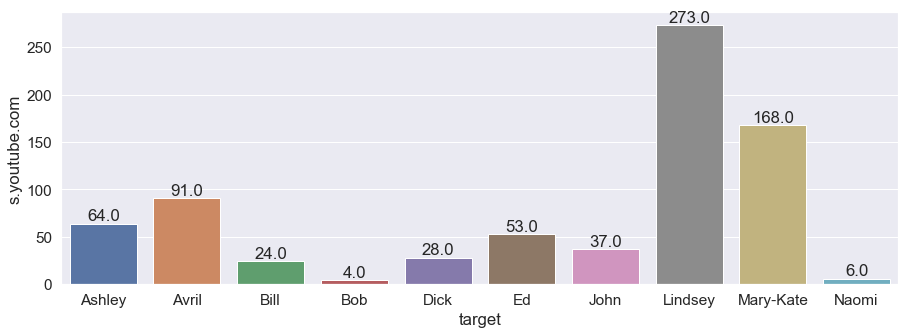

In [146]:
site_plot('s.youtube.com')

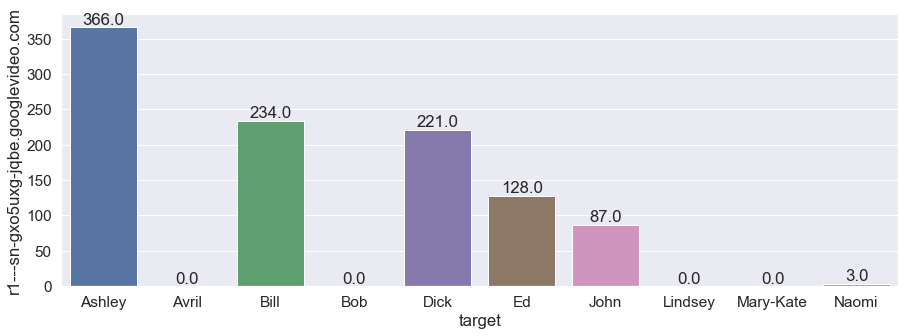

In [150]:
site_plot('r1---sn-gxo5uxg-jqbe.googlevideo.com')

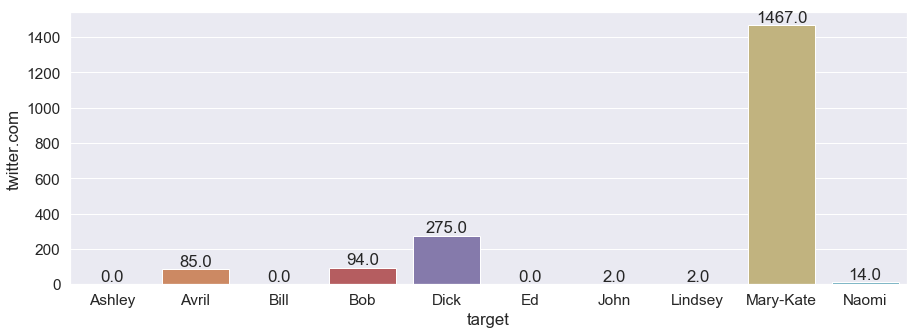

In [148]:
site_plot('twitter.com')

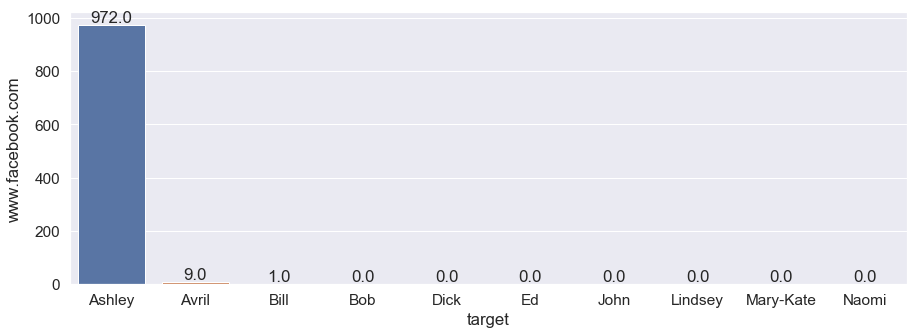

In [149]:
site_plot('www.facebook.com')

##### Вывод - даже на основе count графиков по 4-м сайтам из топ-30 можно заключить, что поведение пользователей существенно отличается. Так, например, Ashley явно предпочитает пользоваться сервисом facebook, а Lindsey довольно часто пользуется youtube в сравнении с остальными пользователями. Поэтому признаки-индикаоры посещения сайтов из топ-30 могут быть полезны при решении задачи классификации.

#### Построим гистограмму распределения признака "Event_top30" - индикатор посещения сайта из топ-30

Text(0.5, 0, 'event_top30')

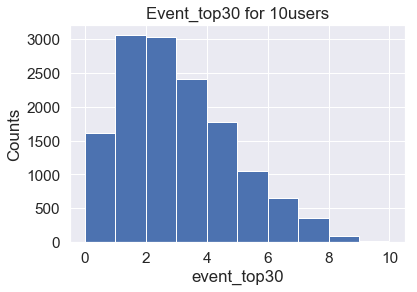

In [151]:
data2['event_top30'].hist(grid=True)
plt.title('Event_top30 for 10users')
plt.ylabel('Counts')
plt.xlabel('event_top30')

#### Видим, что за сессю как правило посещается от 1 до 3 сайтов из списка топ-30. Теперь посмотрим на распределение этого признака по пользователям

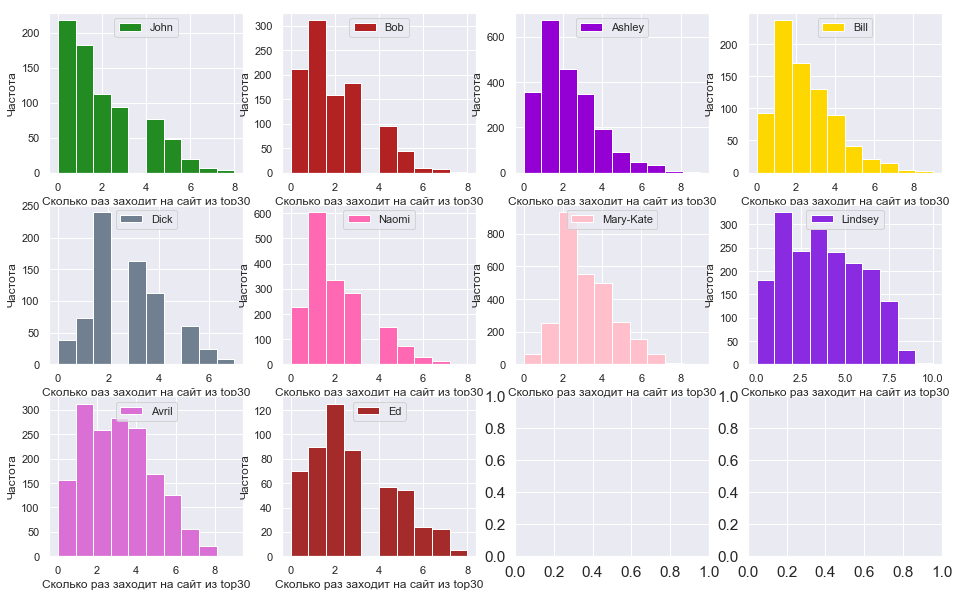

In [153]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
id_ = 0
set(font_scale=1)
for name in (data2.target.unique()):
    id_ += 1
    plt.subplot(3, 4, id_)
    data2[data2.target == name]['event_top30'].hist(color = color_dic[name], label=name)
    plt.legend(loc='upper center')
    plt.ylabel('Частота')
    plt.xlabel('Сколько раз заходит на сайт из top30')

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
id_ = 0
set(font_scale=1)
for name in (data2.target.unique()):
    id_ += 1
    plt.subplot(3, 4, id_)
    df = data2[data2.target==name].pivot_table(index='event_top30', columns='day_of_week', values='target', aggfunc='count')
    plt.legend(loc='upper center')
    plt.ylabel('Частота')
    plt.xlabel('Сколько раз заходит на сайт из top30')

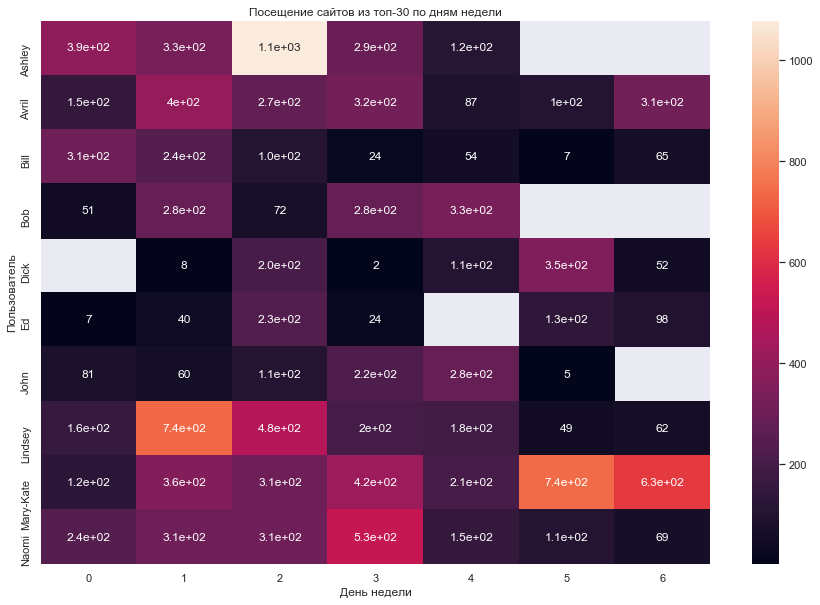

In [156]:
plt.figure(figsize=(15, 10))
df = data2.pivot_table(index='target', columns='day_of_week', values='event_top30', aggfunc='count')
ax = sns.heatmap(df, annot=True)
ax.set(xlabel='День недели', ylabel='Пользователь', title='Посещение сайтов из топ-30 по дням недели')

[Text(156.453125, 0.5, 'Пользователь'),
 Text(0.5, 66.5, 'Час начала сессии'),
 Text(0.5, 1.0, 'Посещение сайтов из топ-30 по дням недели')]

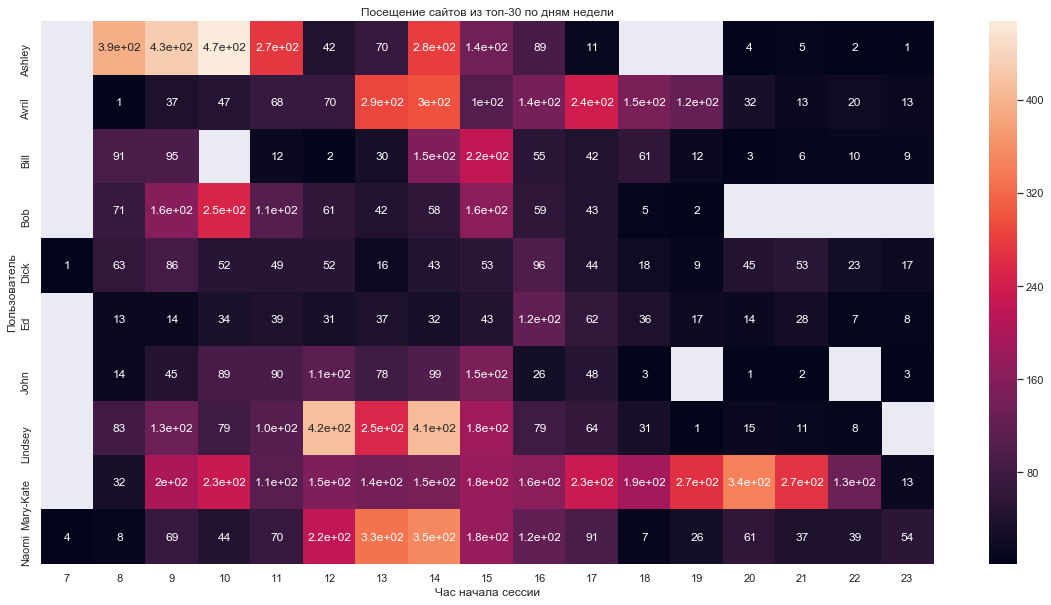

In [158]:
plt.figure(figsize=(20, 10))
df = data2.pivot_table(index='target', columns='start_hour', values='event_top30', aggfunc='count')
ax = sns.heatmap(df, annot=True)
ax.set(xlabel='Час начала сессии', ylabel='Пользователь', title='Посещение сайтов из топ-30 по дням недели')

##### По представленным графикам количества посещений сайтов топ-30 от дня недели и часа начала сессии поведение пользователей также имеет свои характерные особенности: так, Bob и Ashley не склонны к посещению популярных сайтов в 5-й и 6-й дни недели, а Mary-Kate проявляет повышенную активность в течение каждого дня недели и, как мы уже убедились, она чаще всех посещает twitter 

### 4. Сравнение алгоритмов классификации и выбор лучшего алгоритма классификации из рассмотренного семейства алгоритмов с      точки зрения достижения максимального значения метрики ROC-AUC.

#### Проведем сравнение нескольких алгоритмов на сессиях из 10 сайтов

#### 4.1. Подготовка

#### Загрузим обучающую выборку и метки классов

In [159]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

#### Разобьем обучающую выборку на 2 части и одну будем использовать для валидации

In [162]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, random_state=17, stratify=y_10users)

#### Зададим тип кросс-валидации

In [163]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

#### 4.2. Обучим несколько алгоритмов и посмотри на их точность на кросс-валидации и на отложенной выборке

In [166]:
clfs = [LogisticRegression(n_jobs=-1, random_state=17),
        KNeighborsClassifier(n_neighbors=100, n_jobs=-1),
        RandomForestClassifier(n_estimators = 100, random_state=17, oob_score=True),
        LinearSVC(C = 1, random_state=17)
       ]

In [177]:
score_train = []
score_valid = []
for clf in clfs:
    clf.fit(X_train, y_train)
    pred = clf.predict(X_valid)
    score_train.append(round(cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = skf, n_jobs = -1).mean(), 3))
    score_valid.append(round(accuracy_score(y_valid, pred), 3))
df = pd.DataFrame(data = np.array([score_train, score_valid]), columns = ['logit', 'KNN', 'Random Forest', 'SVC'], 
                  index = ['score_train', 'score_valid'])

C:\Users\Elena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Elena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Elena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Elena\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [178]:
df

,logit,KNN,Random Forest,SVC
score_train,0.758,0.561,0.712,0.752
score_valid,0.779,0.584,0.731,0.776


#### Согласно представленной таблицы логистическая регрессия показывает лучший результат с точки зрения достижения максимальной точности алгоритма классификации, поэтому следующим этапом попробуем улучшить качество модели путем настройки гиперпараметров

#### 4.3. Настройка гиперпараметров лучшей модели

#### С помощью LogisticRegressionCV подберем параметр C для LogisticRegression 

#### 4.3.1. Настрока параметра С логистической регрессии в широком диапазоне

In [179]:
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs = logit_c_values1, cv = skf, scoring = 'accuracy', multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

C:\Users\Elena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=array([1.00000e-04, 4.64159e-04, 2.15443e-03, 1.00000e-02, 4.64159e-02,
       2.15443e-01, 1.00000e+00, 4.64159e+00, 2.15443e+01, 1.00000e+02]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring='accuracy',
           solver='lbfgs', tol=0.0001, verbose=0)

In [180]:
dict_keys = list(logit_grid_searcher1.scores_.keys())
score_C = []
for i in range (0, len(dict_keys)):
    score_C.append((logit_grid_searcher1.scores_[dict_keys[i]][0] + logit_grid_searcher1.scores_[dict_keys[i]][1]+ 
                   logit_grid_searcher1.scores_[dict_keys[i]][2]) / 3)

In [181]:
logit_mean_cv_scores1 = (np.array(score_C)).mean(axis = 0)

#### Построим график зависимости доли правильных ответов на кросс-валидации от C при переборе в широком диапазоне

Text(0.5, 1.0, 'Зависимость доли правильных ответов на кросс-валидации от C')

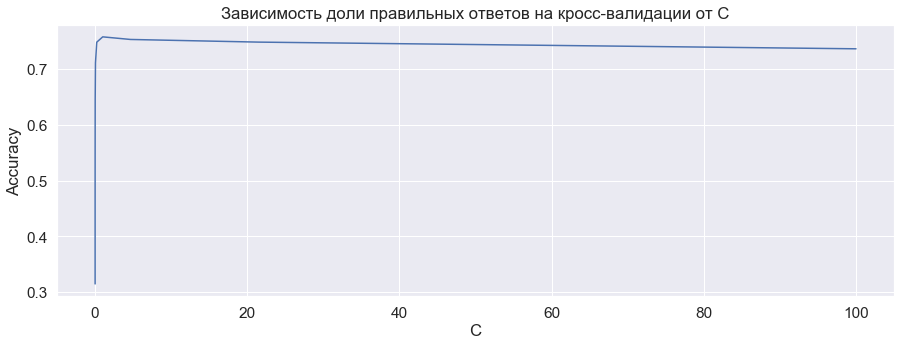

In [185]:
set(font_scale=1.4)
plt.figure(figsize=(15, 5))
plt.plot(logit_c_values1, logit_mean_cv_scores1)
plt.ylabel('Accuracy')
plt.xlabel('С')
plt.title('Зависимость доли правильных ответов на кросс-валидации от C')

#### Согласно представленного графика область перебора параметра С можно граничить диапазоном от 0.1 до 20 - в области максимума графика

#### 4.3.2. Настрока параметра С логистической регрессии на уточненном диапазоне

In [186]:
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, cv = skf, scoring = 'accuracy', multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

C:\Users\Elena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=array([0.1    , 0.46316, 0.82632, 1.18947, 1.55263, 1.91579, 2.27895,
       2.64211, 3.00526, 3.36842, 3.73158, 4.09474, 4.45789, 4.82105,
       5.18421, 5.54737, 5.91053, 6.27368, 6.63684, 7.     ]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring='accuracy',
           solver='lbfgs', tol=0.0001, verbose=0)

In [187]:
dict_keys2 = list(logit_grid_searcher2.scores_.keys())
score2_C = []
for i in range (0, len(dict_keys2)):
    score2_C.append((logit_grid_searcher2.scores_[dict_keys2[i]][0] + logit_grid_searcher2.scores_[dict_keys2[i]][1]+ 
                   logit_grid_searcher2.scores_[dict_keys2[i]][2]) / 3)

In [188]:
logit_mean_cv_scores2 = (np.array(score2_C)).mean(axis = 0)

Text(0.5, 1.0, 'Зависимость доли правильных ответов на кросс-валидации от C на уточненном диапазоне')

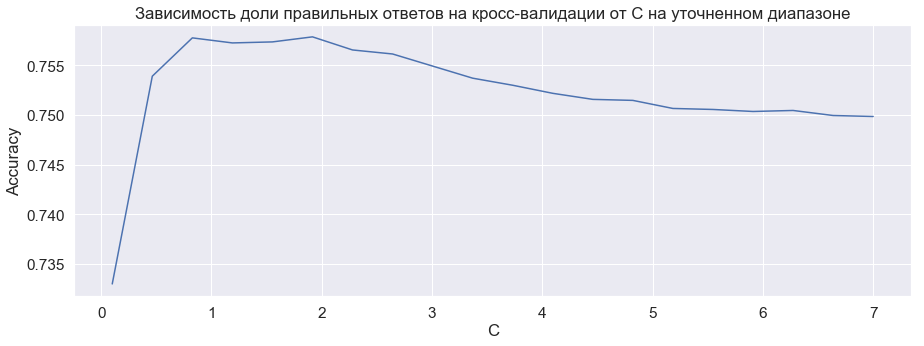

In [189]:
set(font_scale=1.4)
plt.figure(figsize=(15, 5))
plt.plot(logit_c_values2, logit_mean_cv_scores2)
plt.ylabel('Accuracy')
plt.xlabel('С')
plt.title('Зависимость доли правильных ответов на кросс-валидации от C на уточненном диапазоне')

#### Из представленного графика можно заключить, что настройка гиперпараметра С не позволяет улучшить качество метрики accuracy для логистической регрессии и при значении С = 1 модель показывает лучший результат

#### 4.4. Настройка SVC

In [196]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [194]:
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(LinearSVC(random_state=17), svm_params2, scoring = 'accuracy', cv = skf)
grid_svm = svm_grid_searcher2.fit(X_train, y_train)

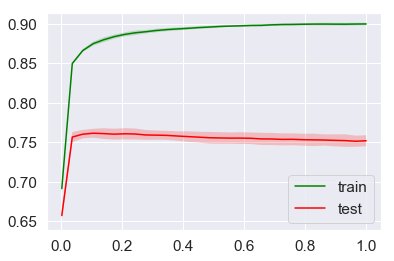

In [197]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

#### Максимум accuracy на валидационной выборке достигается при значении С:

In [198]:
svm_grid_searcher2.best_estimator_.C

0.10434482758620689

#### 4.5. Выбор ширины окна

#### Исследуем влияние длины сессиии и ширины окна на качество модели

In [199]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state, test_size):

    with open(path_to_X_pickle, 'rb') as X_sparse_users_pkl:
        X_sparse = pickle.load(X_sparse_users_pkl)
    with open(path_to_y_pickle, 'rb') as y_users_pkl:
        y = pickle.load(y_users_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size = 0.3, 
                                                          random_state = 17, stratify=y)
    #svm.fit(X_train, y_train)
    cross = cross_val_score(estimator, X_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1).mean()
    pred = estimator.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    score = [0]*2
    score[0] = round(cross, 3)
    score[1] = round(acc, 3)
    
    return score

In [205]:
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15,7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
        print ('session_length:', session_length, 'window_size:', window_size,
               'score:', model_assessment(estimator, path_to_X_pkl,path_to_y_pkl, skf, random_state=17, test_size=0.3))

session_length: 15 window_size: 10 score: [0.816, 0.825]
session_length: 15 window_size: 7 score: [0.842, 0.854]
session_length: 7 window_size: 7 score: [0.751, 0.793]
session_length: 15 window_size: 5 score: [0.863, 0.863]
session_length: 7 window_size: 5 score: [0.772, 0.798]
session_length: 5 window_size: 5 score: [0.724, 0.759]


#### Лучший результат по accuracy на обучении и валидации по данным 10 пользователей показала модель  с длиной сессии = 15 и шириной окна = 5.

#### 4.6. Результат классификации по данным 150 пользователей

#### Результаты многоклассовой классификации по данным 150 пользователей с алгоритмом SVC показали невысокое качество: accuracy на обучении - 0.459 и accuracy на валидации - 0.481.

#### Следующим этапом посмотрим на результаты идентификации каждого конкретного пользователя на выборке из 150 пользователей с помощью логистической регрессии.

In [207]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [208]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, y_150users, test_size=0.3, 
                                                                      random_state=17, stratify=y_150users)

In [212]:
Cs = [logit_grid_searcher2.Cs_[10]]
logit_cv_150users = LogisticRegressionCV(Cs = Cs, cv = skf, multi_class='ovr', random_state=17, n_jobs=-1)

In [213]:
logit_cv_150users.fit(X_train_150, y_train_150)

LogisticRegressionCV(Cs=[3.7315789473684213], class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=17, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

#### Посмотрим на средние доли правильных ответов на кросс-валидации:

In [215]:
cross_val_score(logit_cv_150users, X_train_150, y_train_150, scoring = 'accuracy', cv = skf).mean()

0.4599262877826555

#### Посмотрим на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности

In [216]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = np.mean(logit_cv_150users.scores_[user_id])
    print('User {}, CV score: {}'.format(user_id, np.mean(logit_cv_150users.scores_[user_id])))

User 6, CV score: 0.995871021360082
User 13, CV score: 0.9961841056258778
User 15, CV score: 0.9952142641102646
User 16, CV score: 0.991669316794839
User 28, CV score: 0.9899701088387377
User 31, CV score: 0.994130060281146
User 33, CV score: 0.9935565278813057
User 39, CV score: 0.9857266550426096
User 46, CV score: 0.9978835949776713
User 49, CV score: 0.9951208754458479
User 50, CV score: 0.9941717862599098
User 53, CV score: 0.993567030697907
User 65, CV score: 0.9968305005199166
User 66, CV score: 0.994713828147978
User 82, CV score: 0.996350826567391
User 85, CV score: 0.9962673246877181
User 89, CV score: 0.9904600507164153
User 92, CV score: 0.9942659691892574
User 100, CV score: 0.9944740897313146
User 102, CV score: 0.9912943789844549
User 103, CV score: 0.9805762395875561
User 105, CV score: 0.9968514877410408
User 106, CV score: 0.9947450358419175
User 118, CV score: 0.9910229069066242
User 119, CV score: 0.9966949833803934
User 120, CV score: 0.994265695577464
User 126, CV

#### Результаты кажутся впечатляющими, но возможно, однако это можно объяснить дисбаллансом классов, и высокую долю правильных ответов можно получить константным прогнозом. Для оценки алгоритма в таком случае метрика ROC-AUC является более показательной.

#### По результатам данном раздела лучшее качество на метрике accuracy показал алгоритм логистической регрессии.

### 5. Результаты соревнования Catch me if you can

#### Что было опробовано в ходе соревнования Kaggle "Catch me if you can":


- удаление из обучающей выборки сайтов, которые встречаются n раз;
- CountVectorizer и TF-IDFVectorizer;
- Добавление новых признаков: Длина сессии, количество сайтов из топ-30, время проведенное на сайтах из топ-30 и кол-во уникальных сайтов в сессии; месяц, день и час начала сессии и некоторые связанные с ними бинарные признаки; время, проведенное на каждом сайте; частота посещения сайтов из топ-30 тех, которые нравятся Элис;
- настройка параметров логистической регрессии;
- ансамбль методов для создания метапризнаков;
- блендинг ответов бустинга и логистической регрессии;
- выделение главных компонент и обучение на них простой нейросети; 
- различные кодировки категориальных признаков (Mean_encoding withot regularization, Smoothing regularization, Expanding regularization) - данные методы с имеющимся набором признаков так и не помогли значительно повысить оценку на лидерборде. Вероятнее всего, самый эффективный способ в данной задаче - генерация большего количества вариативных признаков.

In [219]:
feats_numeric = pickle.load(open(os.path.join(PATH_TO_DATA, 'feats_numeric.pkl'), 'rb'))
new_feats2 = pickle.load(open(os.path.join(PATH_TO_DATA, 'new_feats2.pkl'), 'rb'))
data_delta = pickle.load(open(os.path.join(PATH_TO_DATA, 'data_delta.pkl'), 'rb'))
freq_sites_full_30 = pickle.load(open(os.path.join(PATH_TO_DATA, 'freq_sites_full_30.pkl'), 'rb'))

#### Длина сессии, количество сайтов из топ-30, время проведенное на сайтах из топ-30 и кол-во уникальных сайтов в сессии:

In [220]:
feats_numeric.head()

,session_timespan,event_30,time_top30,unique
0,0,0,0,1
1,26,0,0,7
2,7,3,2,4
3,270,10,270,1
4,246,1,137,4


#### Месяц, день и час начала сессии и некоторые связанные с ними бинарные признаки:

In [221]:
new_feats2.head()

,start_month,start_hour,day_of_week,is_work_day,is_holiday,is_morning,is_midday,is_after_midday,is_evening,is_night,is_winter,is_spring,is_summer,is_autumn
0,2,10,3,1,0,1,0,0,0,0,1,0,0,0
1,2,11,5,0,1,0,1,0,0,0,1,0,0,0
2,12,16,0,1,0,0,0,1,0,0,1,0,0,0
3,3,10,4,1,0,1,0,0,0,0,0,1,0,0
4,2,10,4,1,0,1,0,0,0,0,1,0,0,0


#### Время, проведенное на каждом сайте:

In [222]:
data_delta.head()

,delta_time1,delta_time2,delta_time3,delta_time4,delta_time5,delta_time6,delta_time7,delta_time8,delta_time9
0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,23,1
2,1,1,0,0,0,1,1,1,2
3,30,30,30,30,30,30,30,30,30
4,137,0,1,0,36,0,0,67,5


#### Частота посещения сайтов из топ-30 тех, которые нравятся Элис:

In [223]:
freq_sites_full_30.head()

,google.com,google.fr,Unknown.Unknown,facebook.com,nih.gov,annotathon.org,youtube.com,bing.com,live.com,twitter.com,...,geotrust.com,wikipedia.org,baidu.com,msn.com,ac.uk,verisign.com,jboss.org,cloudfront.net,openclassrooms.com,cedexis.com
0,0,0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0


#### Что из перечисленного сработало или финальная модель с использованием алгоритма логистической регрессии:

- удаление из обучающей выборки сайтов, которые встречаются 1,2 или 3 раза помогло повысить качество алгоритма на метрике ROC-AUC, так мы избавились от признаков, не позволяющих алгоритму выстроить определенную зависимость;
- выбранной кодировкой для категориальных признаков (сайтов) остался метод One-Hot_Encoding;
- добавление новых признаков: значительно улучшить качество работы алгоритма на метрике ROC-AUC помогли признаки, основанные на времени - месяц, день и час начала сессии, остальные опробованные признаки и в том числе некоторые их комбинации либо не увеличивали показатель метрики, либо ухудшали его;
- на данном промежуточном этапе лучшая модель - данные о сайтах, которые встречаются в выборке чаще, чем 3 раза, в совокупности с временными признаками - месяц, день и час начала сессии, все перечисленные признаки являются категориальными и закодированы метод One-Hot_Encoding; алгоритм минимизации функционала качества - LogisticRegression(С=1). Значение метрики ROC-AUC на етстовой выборке - 0.94698.
- бленгдинг и ансамбль методов для создания метапризнаков по показателю ROC-AUC не смогли превзойти качества лучшей модели. Значение ROC AUC близко к лучшему значению, которого удалось достичь. 

#### Окончательной оценка на лидерборде - 0.94698, позиция - 1402, ID на Kaggle - Elena Margatckaia

### Заключение

####  При идентификации конкерного пользователя "Элис" на данных соревнования Kaggle алгоритм LogisticRegression с параметром С = 1 показал лучшее значение метрики ROC-AUC = 0.94698 на тестовой выборке. Учитывая линейный характер алгоритма можно заключить, что построенная модель позволяет достаточно определенно идентифицировать поведение конкретного человека в сети, зная только посещенные им сайты и время их посещения.
#### Как мы можем это использовать? 
#### С помощью библиотеки Vowpal Wabbit можно организовать быстрое и эффективное онлайн-обучение алгоритма и улучшать надежность своих ресурсов/ предлагать пользователям сервис по выявлению подозрительных действий на их учетных записях/почтовых ящиках. В настоящее время уже стали популярными сервисы онлайн-банкинга и в подобных системах степень надежности сервиса является ключевым показателем в вопросах привлечения новых клиентов и сохранения уже имеющейся клиентской базы. Так, в подобной системе разработанный алгоритм можно использовать в качестве одного из механизмов распознавания мошеннеческих действий на аккаунте пользователя.